In [29]:
import rioxarray
import rasterio
import glob
import xarray as xr
import numpy as np

In [2]:
from geomod import predictor
from geomod import utils

### Preparing the Data

In [3]:
data_directory = '/home/jovyan/PlanetaryComputerExamples/adv-python-final/geomod/example-notebooks/data/'

In [4]:
driver_map_names = ['elevation01', 'geology01', 'protection01']
driver_map_paths = [data_directory+name+'.rst' for name in driver_map_names]
driver_map_xr_list = [rioxarray.open_rasterio(map, masked=True) for map in driver_map_paths]
all_driver_maps_xr = xarray.concat(driver_map_xr_list, dim='band').assign_coords(band=driver_map_names)

In [5]:
all_driver_maps_xr = all_driver_maps_xr.round().astype('int')

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [6]:
classification_map_xr = rioxarray.open_rasterio(data_directory+'1985anderson01.rst', masked=True)

In [7]:
def get_metadata(rdc_file):
# Open the text file for reading
    metadata_dict = {}
    with open(rdc_file, "r") as file:
    # Read each line in the file
        for line in file:
            # Split each line into key and value using ':'
            key, value = line.strip().split(':')[0:2]
            # Store the key-value pair in the dictionary
            metadata_dict[key.strip()] = value.strip()
    return metadata_dict

In [8]:
print(get_metadata(data_directory+'1985anderson01.RDC'))

{'file format': 'IDRISI Raster A.1', 'file title': '1985 Anderson Land Category', 'data type': 'byte', 'file type': 'binary', 'columns': '512', 'rows': '512', 'ref. system': 'spc83ma1', 'ref. units': 'm', 'unit dist.': '1.0000000', 'min. X': '242160.0000000', 'max. X': '257520.0000000', 'min. Y': '923060.0000000', 'max. Y': '938420.0000000', "pos'n error": 'unknown', 'resolution': '30', 'min. value': '0', 'max. value': '7', 'display min': '0', 'display max': '7', 'value units': 'categories', 'value error': 'unknown', 'flag value': '0', "flag def'n": 'background', 'legend cats': '7', 'code      1': 'Built', 'code      2': 'Agriculture', 'code      3': 'Range', 'code      4': 'Forest', 'code      5': 'Water', 'code      6': 'Wetland', 'code      7': 'Barren', 'lineage': '3*C'}


In [9]:
input_classification_map_xr = rioxarray.open_rasterio(data_directory+'1985anderson01.rst', masked=True)
land_cover_map = utils.reclassify_landcover_map(input_classification_map_xr, 1)

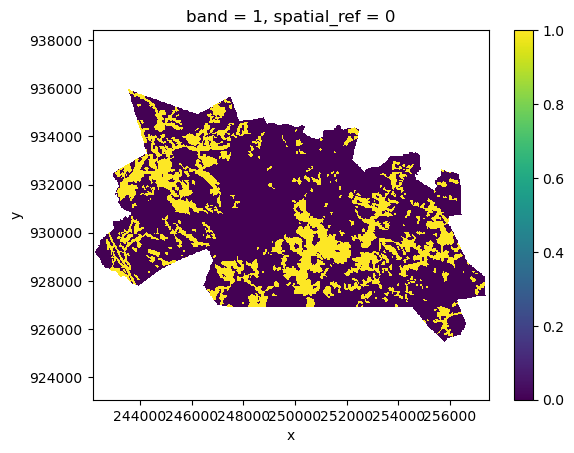

In [10]:
land_cover_map.plot()

In [11]:
validation_class_map_xr = rioxarray.open_rasterio(data_directory+'1999anderson01.rst', masked=True)
validation_map = utils.reclassify_landcover_map(validation_class_map_xr, 1)

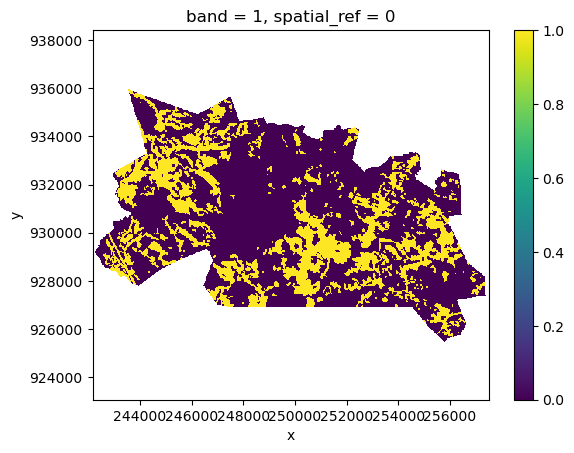

In [12]:
validation_map.plot()

In [17]:
# reclassify maps to suitability 0-100
# first, get reclassification schemes by getting percent developed for each category

reclass_maps = {}
num_bands = all_driver_maps_xr.shape[0]
for band in all_driver_maps_xr['band']:
    percent_developed = {}
    bandarray = all_driver_maps_xr.sel(band=band)
    band_categories = np.unique(bandarray).tolist()
    for category in band_categories:
        category_cells = bandarray == category
        developed_cells = (category_cells & (land_cover_map == 1)).sum().item()
        total_cells = category_cells.sum().item()
        percent_developed[category] = developed_cells / total_cells *100 if total_cells > 0 else 0
    reclass_maps[str(band.values)] = percent_developed

In [30]:
# use reclass to get 0-100 driver maps
driver_maps_as_suitability = utils.driver_map_classification(all_driver_maps_xr, reclass_maps)

In [38]:
weights = {'elevation01':.40, 'protection01':.20, 'geology01':.40}
weighted_sum = sum(driver_maps_as_suitability.sel(band=band) * weight for band, weight in weights.items())

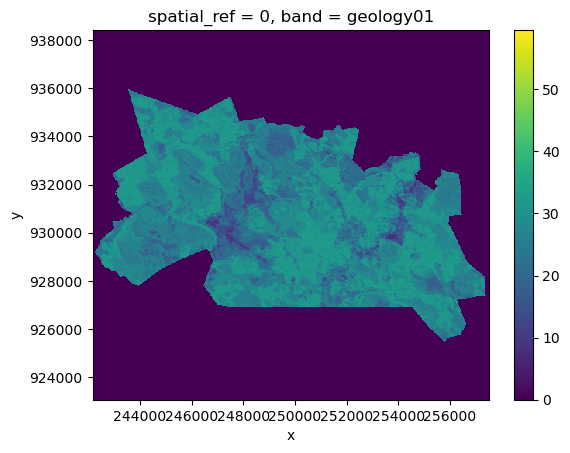

In [39]:
weighted_sum.plot()